# TD05 : Classification d'images

In [10]:
import numpy as np
from skimage.color import rgb2gray
import matplotlib.pyplot as plt
from scipy.spatial import distance_matrix
from skimage.feature import daisy
from skimage import io
import time

Une fonction d'utilité définie par le prof: calcul les descripteurs DAISY d'une image et reshape le tableau obtenu pour le rendre exploitable pour du ML.

In [2]:
def d_daisy(im):
    """
    Calcul des caractéristiques DAISY sous la forme d'un tableau
    """
    descs = daisy(im, step=16, radius=16, rings=3, histograms=8,
                  orientations=8, visualize=False)
    return np.reshape(descs,
                      (descs.shape[0]*descs.shape[1], descs.shape[2]),
                      order='F')

On importe les images et on les convertit en N&B.

In [6]:
images = [rgb2gray(e) for e in io.imread_collection('images/*')]

On définit un tableau de descripteurs correspondant aux DAISY des images de training en prenant le code du prof parceque flemme de faire les choses proprement avec le tablelau construit juste au dessus !

In [8]:
descr_num = np.zeros(300)
descr = np.empty((0,200))
for i in range(300):
    im = rgb2gray(plt.imread('images/%03d.jpg'%(i)))
    descr = np.concatenate((descr, d_daisy(im)))
    descr_num[i] = len(descr)

Clustering pour construire le dictionnaire de mots visuels

In [9]:
from sklearn.cluster import KMeans
n_clust = 20
kmeans = KMeans(n_clusters=n_clust)
kmeans.fit(descr)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=20, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

On décrit les images sous la forme d'un histogramme sur le disctionnaire

In [12]:
start_time = time.time()
label = kmeans.predict(descr)
descr_hist = np.zeros((300,n_clust))
for i in range(300):
    i_start = int(descr_num[i-1]) if i > 0 else 0
    i_end = int(descr_num[i])
    descr_hist[i,:] = np.bincount(label[i_start:i_end], minlength=n_clust)
    descr_hist[i,:] /= np.sum(descr_hist[i,:])
print("Exec time : ", time.time() - start_time)

Exec time :  0.35097408294677734


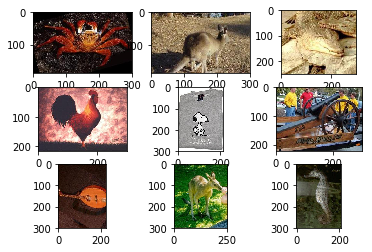

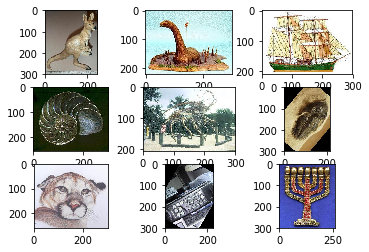

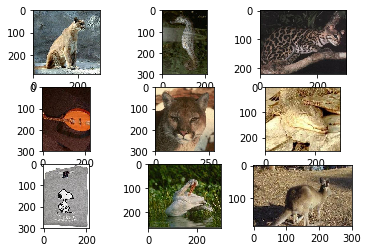

In [13]:
# Recherche des images les plus proches
img = ['crab.jpg', 'kangaroo.jpg', 'cougar.jpg']
for i in range(len(img)):
    im0 = rgb2gray(plt.imread(img[i]))
    descr0 = d_daisy(im0)
    label0 = kmeans.predict(descr0)
    descr_hist0 = np.array([np.bincount(label0, minlength=n_clust)]).astype(float)
    descr_hist0 /= np.sum(descr_hist0)
    
    d = distance_matrix(descr_hist0, descr_hist)
    d_i = np.argsort(d[0,:])
    
    plt.figure(img[i])
    plt.clf()
    plt.subplot(3,3,1)
    plt.imshow(plt.imread(img[i]))
    for i in range(2, 9+1):
        plt.subplot(3,3,i)
        plt.imshow(plt.imread('images/' + '%03d'%(d_i[i-2]) + '.jpg'))